In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#https://jovian.ai/shreekanya/03-cifar10-feedforward

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3607).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3961).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3958).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3643).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(4088).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3679).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3506).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(4161).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(4121).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3534).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3596).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3460).jpg
/kag

In [45]:
BASE_PATH = '../input/covid19-pneumonia-normal-chest-xray-pa-dataset/'

In [46]:
image=[]
labels=[]
for file in os.listdir(BASE_PATH):
    if file=='covid':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            image.append(c)
            labels.append('covid')
    if file=='normal':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            image.append(c)
            labels.append('normal')
    if file=='pneumonia':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            image.append(c)
            labels.append('pneumonia')
data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data.head()

,Images,labels
0,00025583_005.png,pneumonia
1,person1513_virus_2632.jpeg,pneumonia
2,person124_virus_238.jpeg,pneumonia
3,person466_virus_960.jpeg,pneumonia
4,person59_bacteria_279.jpeg,pneumonia


In [47]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,00025583_005.png,pneumonia,2
1,person1513_virus_2632.jpeg,pneumonia,2
2,person124_virus_238.jpeg,pneumonia,2
3,person466_virus_960.jpeg,pneumonia,2
4,person59_bacteria_279.jpeg,pneumonia,2


In [48]:
batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

In [49]:
from PIL import Image

In [50]:
from torch.utils.data.sampler import SubsetRandomSampler
# Creating data indices for training and validation splits:
# from sklearn.model_selection import train_test_split
# tr, val = train_test_split(data.label, stratify=data.label, test_size=0.1)
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#train_indices is equivalent to list(tr.index)
#val_indices is equivalent to list(val.index)

In [51]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [52]:
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5, 0.5,0.5))])

In [53]:
from torch.utils.data import Dataset
class chest_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [54]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [55]:
dataset = chest_Dataset(data,BASE_PATH,transform)

In [56]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [57]:

def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

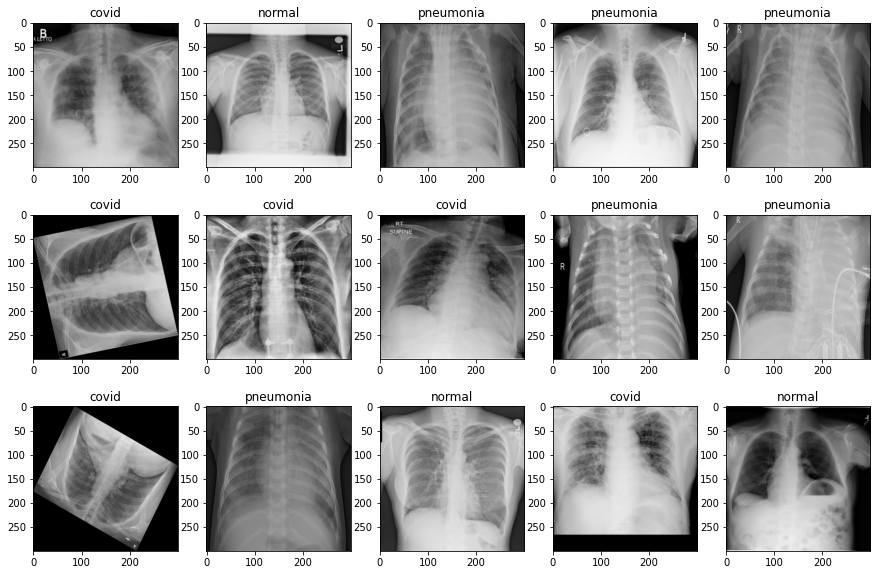

In [58]:
import matplotlib.pyplot as plt
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'covid', 1: 'normal', 2: 'pneumonia'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [59]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [60]:
import torch.nn as nn
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [61]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [62]:
torch.cuda.is_available()

True

In [63]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [64]:
device = get_default_device()
device

device(type='cuda')

In [65]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [66]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [67]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [68]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(validation_loader, device)
#test_loader = DeviceDataLoader(test_loader, device)

In [69]:
print('images.shape:', images.shape)

images.shape: torch.Size([128, 3, 300, 300])


In [70]:
input_size = 3*300*300
output_size = 3

In [71]:
import torch.nn.functional as F
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

In [72]:
model = to_device(CIFAR10Model(), device)

In [73]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.1008292436599731, 'val_acc': 0.3190034329891205}]

In [74]:
history += fit(10,0.01, model, train_loader, val_loader, torch.optim.Adam)

Epoch [0], val_loss: 1.3505, val_acc: 0.7368
Epoch [1], val_loss: 1.0291, val_acc: 0.7609
Epoch [2], val_loss: 0.8633, val_acc: 0.7545
Epoch [3], val_loss: 0.7174, val_acc: 0.7809
Epoch [4], val_loss: 0.8500, val_acc: 0.7827
Epoch [5], val_loss: 0.8887, val_acc: 0.8055
Epoch [6], val_loss: 0.9200, val_acc: 0.7595
Epoch [7], val_loss: 0.8206, val_acc: 0.7754
Epoch [8], val_loss: 0.6622, val_acc: 0.7678
Epoch [9], val_loss: 0.6759, val_acc: 0.6474


In [76]:
torch.save(model.state_dict(), 'model_weights.pth')
model = torch.load('model_weights.pth')

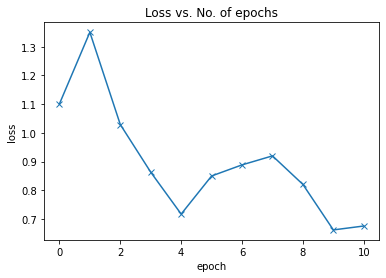

In [77]:
plot_losses(history)

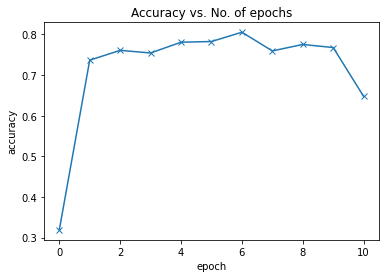

In [78]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_loader)